In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# Random forest - Véletlen erdő

A következő példával szeretnénk a véletlen erdő működését bemutatni.
A kiinduló adatbázisunk egy munkahelyen vizsgált képek számát mutatja, alkalmazottakra és időre bontva.
Ezeken felül az adott időpontig elfogyasztott kávék számát és az alkalmazottak korát mutatja még a csv fájlunk.
A "Productivity" oszlopban az érték "Good", ha legalább 17 képet ellenőrzött az alkalmazott, különben "Bad".

Beolvassuk az adatbázisunkként szolgáló adat2_new.csv fájlt

In [2]:
datas=pd.read_csv('adat2_newer.csv')

Leellenőrizzük a beolvasott adatbázist, az első öt sora alapján

In [3]:
datas.head()

,User,Time,Coffee,Age,Images_Analyzed,Productivity
0,1,8,0,23,20,Good
1,1,13,0,23,14,Bad
2,1,17,0,23,18,Good
3,1,22,0,23,15,Bad
4,1,8,2,23,22,Good


In [4]:
print(datas)

    User  Time  Coffee  Age  Images_Analyzed Productivity
0      1     8       0   23               20         Good
1      1    13       0   23               14          Bad
2      1    17       0   23               18         Good
3      1    22       0   23               15          Bad
4      1     8       2   23               22         Good
..   ...   ...     ...  ...              ...          ...
80     1     8       0   23               20         Good
81     2     6       0   65               19         Good
82     3     7       0   31               21         Good
83     4     8       0   45               22         Good
84     5     9       0   52               21         Good

[85 rows x 6 columns]


A programunk lényege az lesz, hogy megjósoljuk a teljes "Productivity" oszlop értékét az adataink alapján.
Erre alkalmas a Random Forest módszere.
A jósolt érték kiszámítása után, megkaphatjuk a jóslat pontosságát és a tényezőink fontosságát.

Lekérjük a "Productivity" oszlop értékeinek számát

In [5]:
sizes=datas['Productivity'].value_counts(sort=1)
print(sizes)

Good    43
Bad     42
Name: Productivity, dtype: int64


Mivel már nincs szükségünk az "Images_Analyzed" oszlopra,mert tudjuk hogy melyik sor Good vagy Bad, ezért azt kivesszük az adatbázisunkból

In [6]:
datas.drop(['Images_Analyzed'],axis=1,inplace=True)

In [7]:
print(datas)

    User  Time  Coffee  Age Productivity
0      1     8       0   23         Good
1      1    13       0   23          Bad
2      1    17       0   23         Good
3      1    22       0   23          Bad
4      1     8       2   23         Good
..   ...   ...     ...  ...          ...
80     1     8       0   23         Good
81     2     6       0   65         Good
82     3     7       0   31         Good
83     4     8       0   45         Good
84     5     9       0   52         Good

[85 rows x 5 columns]


A "User" oszlopot töröljük, mert az összes alkalmazott munkáját együtt szeretnénk elemezni

A feladatunk elvégzéséhez tehát a "Time","Coffee","Age" és "Productivity" oszlopokra lesz csak szükségünk

In [8]:
datas.drop(['Coffee'],axis=1,inplace=True)

In [9]:
print(datas)

    User  Time  Age Productivity
0      1     8   23         Good
1      1    13   23          Bad
2      1    17   23         Good
3      1    22   23          Bad
4      1     8   23         Good
..   ...   ...  ...          ...
80     1     8   23         Good
81     2     6   65         Good
82     3     7   31         Good
83     4     8   45         Good
84     5     9   52         Good

[85 rows x 4 columns]


In [10]:
datas=datas.dropna()
#Üres adatok törlése,nincs ilyen a példa adathalmazban,de hasznos lehet

In [11]:
print(datas)

    User  Time  Age Productivity
0      1     8   23         Good
1      1    13   23          Bad
2      1    17   23         Good
3      1    22   23          Bad
4      1     8   23         Good
..   ...   ...  ...          ...
80     1     8   23         Good
81     2     6   65         Good
82     3     7   31         Good
83     4     8   45         Good
84     5     9   52         Good

[85 rows x 4 columns]


A Productivity oszlop értékeit számokká alakítjuk a következőképpen:

In [12]:
datas.Productivity[datas.Productivity == 'Good'] = 1
datas.Productivity[datas.Productivity == 'Bad'] = 2

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
print(datas)

    User  Time  Age Productivity
0      1     8   23            1
1      1    13   23            2
2      1    17   23            1
3      1    22   23            2
4      1     8   23            1
..   ...   ...  ...          ...
80     1     8   23            1
81     2     6   65            1
82     3     7   31            1
83     4     8   45            1
84     5     9   52            1

[85 rows x 4 columns]


Definiáljuk az Y változót : "Productivity" oszlop értékei

In [14]:
Y = datas['Productivity'].values
Y=Y.astype('int')

Definiáljuk az X változót : a "Time", "Coffee" és "Age" oszlopok értékei

In [15]:
X=datas.drop(labels=['Productivity'],axis=1)

Szétválasztjuk az adatokat tanuló és teszt részekre

A train_test_split függvény szétbontja a táblázatunkat.
A test_size paraméter a szétbontás arányát adja meg. Minél kisebb százalékos értéket adunk itt meg annál pontosabban tudunk jósolni.
A random_state paraméter abban segít, hogy mindig ugyanazt a véletlenszerű szétbontást kapjuk.

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=20)

Írjuk ki az X tanuló készletét

In [17]:
print(X_train)

    User  Time  Age
21     2    12   65
64     5     9   52
73     5    14   52
27     2    20   65
67     5    23   52
..   ...   ...  ...
75     5    23   52
20     2     6   65
9      1    13   23
28     2     6   65
15     1    22   23

[68 rows x 3 columns]


In [18]:
sizesxtrain=X_train['Age'].value_counts(sort=1)
print(sizesxtrain)

65    16
52    15
45    13
23    12
31    12
Name: Age, dtype: int64


68 sorból és 3 oszlopból áll az X tanuló készlete. Ezek a sorok pedig véletlenszerű sorrendben vannak

Írjuk ki az X teszt készletét

In [19]:
print(X_test)

    User  Time  Age
66     5    17   52
51     4    22   45
12     1     8   23
83     4     8   45
36     3     7   31
44     3     7   31
23     2    20   65
0      1     8   23
77     5    14   52
45     3    13   31
50     4    17   45
37     3    13   31
39     3    23   31
48     4     8   45
2      1    17   23
5      1    13   23
1      1    13   23


In [20]:
sizesxtest=X_test['Age'].value_counts(sort=1)
print(sizesxtest)

23    5
31    5
45    4
52    2
65    1
Name: Age, dtype: int64


17 sorból és 3 oszlopból áll az X teszt készlete. Ezek a sorok is véletlenszerű sorrendben vannak

Importáljuk a RandomForestClassifier-t

In [21]:
from sklearn.ensemble import RandomForestClassifier

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method

Elnevezzük model-ként a függvényünket. Az n_estimators paraméter az erdőben lévő fák számát jelöli

In [22]:
model=RandomForestClassifier(n_estimators=10,random_state=30)

Ráillesztjük a model függvényünkre az X és Y tanuló készletét

In [23]:
model.fit(X_train, Y_train)

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/ensemble/forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=30, verbose=0,
                       warm_start=False)

Létrehozzuk a model eredményének jóslását, ehhez pedig a X teszt készletét használjuk

In [24]:
prediction_test=model.predict(X_test)

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


Kiírjuk a jóslati eredményeket

In [25]:
print(prediction_test)

[1 2 1 1 1 1 2 1 2 2 1 2 2 1 1 2 2]


1-esből 9 darab, 2-esből 8 darab eredményünk van, tehát a többségben lévő 1-es a végső megoldásunk, ami a "Good" értéket helyettesítette.

In [26]:
from sklearn import metrics

Az accuracy_score felhasználásával összevetjük az Y teszt készletét és a jóslati eredményeket, így megkapjuk a jóslat pontosságát

In [27]:
print("Accuracy = ", metrics.accuracy_score(Y_test, prediction_test))

Accuracy =  1.0


100% a jóslati eredmény pontossága.

A feature_importances_ segítségével megkapjuk, hogy melyik tényező milyen százalékban befolyásolta a jóslati eredményt

In [28]:
print(model.feature_importances_)

[0.07152546 0.89617243 0.03230211]


In [29]:
feature_list= list(X.columns)
feature_imp=pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)

In [30]:
print(feature_imp)

Time    0.896172
User    0.071525
Age     0.032302
dtype: float64


Hozzunk létre egy konfúziós mátrixot az Y teszt készlete és a jóslati eredmény között

In [31]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, prediction_test)
print(cm)
metrics.accuracy_score(Y_test,prediction_test)

[[9 0]
 [0 8]]


1.0

Text(-3.0, 0.5, 'Truth')

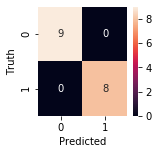

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(2,2))
sn.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [33]:
print(Y_test)

[1 2 1 1 1 1 2 1 2 2 1 2 2 1 1 2 2]


In [34]:
print(prediction_test)

[1 2 1 1 1 1 2 1 2 2 1 2 2 1 1 2 2]
